# 数据清洗与探查（共享单车）



# 数据概览

本分析将使用修改后的Bike_Sharing数据集，与原始数据集不同，此修改版本为了强调对缺失数据的处理，包含Nulls和Zeros。

## 特征信息
    数据集包含信息介绍如下：

    *  dteday      : 日期（未指定时间）
    *  season      : 季节（春、夏、秋、冬）
    *  hr        :  小时 (0 to 23)
    *  holiday     : 是否假期
    *  weekday     : 星期几
    *  workingday   : 如果既不是周末也不是假期则为1，否则为0
    *  weathersit   : 天气情况（晴、多云、小雪、雷暴）
    *  temp       : 标准化温度（摄氏度）
                 (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
    *  atemp      : 归一化体感温度（摄氏度） 
    				   (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    *  Hum        : 标准化湿度. The values are divided to 100 (max)
    *  Windspeed    : 标准化风速. The values are divided to 67 (max)
    *  Cnt        : 租赁自行车总数



In [13]:
import pandas as pd
import numpy  as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

from matplotlib import dates as mdates
import calendar
from datetime import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# import warnings
# warnings.filterwarnings('ignore')

In [14]:
# pd.options.display.float_format    = '{:,.3f}'.format  
df = pd.read_csv('./data/bikesharing_modified.csv')

ordFeatures   = ['hr']
boolFeatures  = ['holiday','workday']
contFeatures  = ['temp','atemp','hum','windspeed']
nomFeatures   = ['season','weekday','weathersit']
target        = ['cnt']

df.head()

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1/1/2011,spring,0,0,Saturday,0,Clear,0.24,0.2879,0.81,0.0,16
1,1/1/2011,spring,1,0,Saturday,0,Clear,0.22,0.2727,0.80,0.0,40
2,1/1/2011,spring,2,0,Saturday,0,Clear,0.22,0.2727,0.80,0.0,32
3,1/1/2011,spring,3,0,Saturday,0,Clear,0.24,0.2879,0.75,0.0,13
4,1/1/2011,spring,4,0,Saturday,0,Clear,0.24,0.2879,0.75,0.0,1


In [15]:
df.dtypes

dteday         object
season         object
hr              int64
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [16]:
df.describe()

,hr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17369.000000,17379.000000,17366.000000,17379.000000,17379.000000
mean,11.546752,0.028770,0.682721,0.497035,0.475775,0.627176,0.190098,189.463088
std,6.914405,0.167165,0.465431,0.192589,0.171850,0.192921,0.122340,181.387599
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,12.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,18.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  object 
 2   hr          17379 non-null  int64  
 3   holiday     17379 non-null  int64  
 4   weekday     17379 non-null  object 
 5   workingday  17379 non-null  int64  
 6   weathersit  17379 non-null  object 
 7   temp        17369 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17366 non-null  float64
 10  windspeed   17379 non-null  float64
 11  cnt         17379 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 1.6+ MB


## 利用pandas-profiling处理数据

Pandas-profiling是一个开源Python库，它只需一行代码即可为任何机器学习数据集生成漂亮的交互式报告。

每一列的以下统计数据(如果与列类型相关)都显示在交互式HTML报告中:

- 类型推断：检测DataFrame中列的类型。
- 概要：类型，唯一值，缺失值
- 分位数统计信息，例如最小值，Q1，中位数，Q3，最大值，范围，四分位数范围
- 描述性统计数据，例如均值，众数，标准偏差，和，中位数绝对偏差，变异系数，峰度，偏度
- 最常使用的值
- 直方图
- 高度相关变量（Spearman，Pearson和Kendall矩阵）的相关性突出显示
- 缺失值矩阵，计数（count），热图和缺失值树状图


对于Bike_Sharing数据集，数据类别不多，数据量比较小，适合使用pandas-profiling来一键观察数据的基本信息。

In [20]:
print(matplotlib.get_backend())
import pandas_profiling
pfr = pandas_profiling.ProfileReport(df)
pfr.to_file('shared_bike_report.html')
pfr
print(matplotlib.get_backend())
%matplotlib inline
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline


报告显示了数据集的基本信息，包括先前看到了行列信息，也包括如nulls数量，无重复行等初级的分析信息。对于数据的具体特征，pandas-profiling也给出了分析，不过没有经过处理的数据显得非常凌乱，如dteday包含了726个变量，不应该对每个变量直接进行分析处理。

总体上说，pandas-profiling是一个十分方便的工具，可以经常在规模不大的数据集上做初步分析使用。

也可以用Sweetviz查看数据轮廓

In [22]:
import sweetviz as sv
report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)

In [23]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 特征信息转化
Bike_Sharing数据集具有多种功能类型：日期（dteday），离散文字变量（season, weekday, weathersit），离散数字变量（hr），布尔值（holiday, workingday），连续变量（temp, atemp, hum, windspeed）。并计算（cnt）。为了便于数据处理与建模，添加了以下功能和转换：<br><br>


    dteday          : transformed from Object to Date-time
    year            : derived from 'dteday'
    month           : derived from 'dteday'
    month_int       : ordinal encoding of 'month';  1:Jan, 2:Feb, 3:Mar, …. 12:Dec
    season_int      : ordinal encoding of 'season'  1:spring, 2:summer, 3:fall, 4:winter
    weekday_int     : ordinal encoding of 'weekday' 0:Mond, 1:Tue, 2:Wed, 3:Thu, 4:Fri, 5:Sat, 6:Sun
    weathersit_int  : one-hot encoding of 'weathersit'
    
将原始数据进行处理，把文字信息转换为数字信息，便于后续数据分析工作

In [24]:
df['dteday']      = pd.to_datetime(df['dteday'])
df['year']        = df.dteday.dt.year
df['weekday']     = df.dteday.dt.strftime('%a')
df['month']       = df.dteday.dt.strftime('%b')
df['month_int']   = df.dteday.dt.month
df['weekday_int'] = df.dteday.dt.weekday
df['season_int']      = df['season'].replace(['spring', 'summer', 'fall', 'winter'],[1,2,3,4])
df['Clear']           = df['weathersit']=='Clear'
df['Light Snow']      = df['weathersit']=='Light Snow'
df['Slightly cloudy'] = df['weathersit']=='Slightly cloudy'
df['Thunderstorm']    = df['weathersit']=='Thunderstorm'

df

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,cnt,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm
0,2011-01-01,spring,0,0,Sat,0,Clear,0.24,0.2879,0.81,...,16,2011,Jan,1,5,1,True,False,False,False
1,2011-01-01,spring,1,0,Sat,0,Clear,0.22,0.2727,0.80,...,40,2011,Jan,1,5,1,True,False,False,False
2,2011-01-01,spring,2,0,Sat,0,Clear,0.22,0.2727,0.80,...,32,2011,Jan,1,5,1,True,False,False,False
3,2011-01-01,spring,3,0,Sat,0,Clear,0.24,0.2879,0.75,...,13,2011,Jan,1,5,1,True,False,False,False
4,2011-01-01,spring,4,0,Sat,0,Clear,0.24,0.2879,0.75,...,1,2011,Jan,1,5,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,spring,19,0,Mon,1,Slightly cloudy,0.26,0.2576,0.60,...,119,2012,Dec,12,0,1,False,False,True,False
17375,2012-12-31,spring,20,0,Mon,1,Slightly cloudy,0.26,0.2576,0.60,...,89,2012,Dec,12,0,1,False,False,True,False
17376,2012-12-31,spring,21,0,Mon,1,Clear,0.26,0.2576,0.60,...,90,2012,Dec,12,0,1,True,False,False,False
17377,2012-12-31,spring,22,0,Mon,1,Clear,0.26,0.2727,0.56,...,61,2012,Dec,12,0,1,True,False,False,False


# 数据标记——Nulls, Zeros, Outliers
修改的Bike_Sharing数据集，包含null，zeros和outliers。

## 标记缺失值
nulls是异常值中最急需处理的部分。由于nulls的存在，后续的数据处理过程往往出现致命性的错误，算法通常会返回nulls或者出现错误，使得数据完全无法分析。

相较于zeros和outliers，nulls优先级更高。
结合isna(), sum()可以快速统计出数据集中nulls异常值的分布和数量

In [25]:
df.isna().sum()

dteday              0
season              0
hr                  0
holiday             0
weekday             0
workingday          0
weathersit          0
temp               10
atemp               0
hum                13
windspeed           0
cnt                 0
year                0
month               0
month_int           0
weekday_int         0
season_int          0
Clear               0
Light Snow          0
Slightly cloudy     0
Thunderstorm        0
dtype: int64

得到结果，数据集中temp列存在10个空值，hum中存在13个空值。

由先前得到的结论，只有在温度*'temp'*和湿度*'hum'*中存在Null值。<br>

为了可视化数据，新创建*'outlr_miss'*列，用于存储记录数据的异常值标签。 

*'outlr_miss'*列的标签规则（此时仅有三类标签）如下：<br>

       outlr_miss    
             data  >>>  row with no Nulls or Zeros 
         temp_nan  >>>  temp column has Null values
          hum_nan  >>>  hum column has Null values
 思考: 有没有第四类标签？

In [26]:
# 创建outlr_miss列以标记数据缺失情况。
df['outlr_miss']='data'
df.loc[(df['outlr_miss']=='data') & df['temp'].isna(), 'outlr_miss'] = 'temp_nan'
df.loc[(df['outlr_miss']=='data') & df['hum'].isna(), 'outlr_miss']  = 'hum_nan'
df[df.isnull().any(axis=1)].style.highlight_null(null_color='lightgreen') # 空值显示为绿色

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm,outlr_miss
424,2011-01-19 00:00:00,spring,17,0,Wed,1,Clear,0.360000,0.333300,nan,0.328400,197,2011,Jan,1,2,1,True,False,False,False,hum_nan
514,2011-01-23 00:00:00,spring,13,0,Sun,0,Clear,0.140000,0.106100,nan,0.388100,87,2011,Jan,1,6,1,True,False,False,False,hum_nan
1251,2011-02-25 00:00:00,spring,7,0,Fri,1,Light Snow,0.340000,0.333300,nan,0.134300,35,2011,Feb,2,4,1,False,True,False,False,hum_nan
1681,2011-03-15 00:00:00,spring,16,0,Tue,1,Slightly cloudy,nan,0.393900,0.460000,0.328400,114,2011,Mar,3,1,1,False,False,True,False,temp_nan
3141,2011-05-15 00:00:00,summer,19,0,Sun,0,Clear,0.560000,0.530300,nan,0.104500,231,2011,May,5,6,2,True,False,False,False,hum_nan
5126,2011-08-06 00:00:00,fall,12,0,Sat,0,Clear,0.800000,0.757600,nan,0.223900,382,2011,Aug,8,5,3,True,False,False,False,hum_nan
6239,2011-09-22 00:00:00,fall,13,0,Thu,1,Slightly cloudy,0.660000,0.606100,nan,0.194000,193,2011,Sep,9,3,3,False,False,True,False,hum_nan
6953,2011-10-22 00:00:00,winter,8,0,Sat,0,Clear,nan,0.409100,0.710000,0.000000,114,2011,Oct,10,5,4,True,False,False,False,temp_nan
7566,2011-11-16 00:00:00,winter,21,0,Wed,1,Light Snow,nan,0.439400,0.880000,0.283600,75,2011,Nov,11,2,4,False,True,False,False,temp_nan
7835,2011-11-28 00:00:00,winter,3,0,Mon,1,Clear,nan,0.439400,0.880000,0.223900,5,2011,Nov,11,0,4,True,False,False,False,temp_nan


从统计结果看，得到的输出结果应该恰好有23行显示*'temp_nan'*或*'hum_nan'*标签（10+13）。绿色高亮部分为缺失的空值位置。

## 标记零值
标记完最紧迫的nulls部分后，我们就应该着眼于检查零值特征了。

零值比较特殊，往往也可以以非异常值出现，例如*'hr'*中表示每天的零点，*'holiday'*和*'workingday'*等boolean型中也含有零值。
零值是否是异常值需要根据数据的表示形式和类型来具体判断。具体到本数据集，我们合理判断，在*'atemp'，'hum'*和*'windspeed'*出现零值是比较不合理的。

同样，结合isin(),sum()可以快速统计出零值的分布和数量

In [27]:
df.isin([0]).sum()

dteday                 0
season                 0
hr                   726
holiday            16879
weekday                0
workingday          5514
weathersit             0
temp                   0
atemp                  2
hum                   22
windspeed           2180
cnt                    0
year                   0
month                  0
month_int              0
weekday_int         2479
season_int             0
Clear               5966
Light Snow         15960
Slightly cloudy    12835
Thunderstorm       17376
outlr_miss             0
dtype: int64

统计结果结合我们的判断，在atemp，hum，windspeed三列数据中存在异常的零值。

于是更新*'outlr_miss'*列的标签(此时共有6类数据标签)，以下是这些零值的标签编码：

     outlr_miss       
              data     >>  row with no Nulls or Zeros 
          temp_nan     >>  temp column has Null values
           hum_nan     >>  hum column has Null values
        atemp_zero     >>  atemp column has zero values
          hum_zero     >>  hum column has zero values
    windspeed_zero     >>  hum column has zero values


In [28]:
df.loc[(df['outlr_miss']=='data') & df['atemp'].isin([0]), 'outlr_miss']     = 'atemp_zero' 
df.loc[(df['outlr_miss']=='data') & df['hum'].isin([0]), 'outlr_miss']       = 'hum_zero' 
df.loc[(df['outlr_miss']=='data') & df['windspeed'].isin([0]), 'outlr_miss'] = 'windspeed_zero' 

## 寻找重复值
在真实数据集中，往往由于人为因素存在信息重复的情况，有时候重复率并不低。重复信息的存在显然对后续数据分析有极大影响。因此剔除重复值是必要的一步。

duplicated()是pandas自带的统计重复值的函数，结合sum()可以得到数据的重复情况。

In [29]:
df.duplicated().sum()

0

在此数据集中，没有重复值。若存在，则可以选择剔除重复项，达到回归真实情况的目的。

pandas中的剔除重复值函数：df.drop_duplicates()

## 寻找异常值
- 具体处理方法不变，难点在于找到哪些属于异常值
- 箱型图是一种直观分析数据分散情况的统计图，需要强调的是，箱型图反映的是数据的离散情况，设置的异常值界限存在明显主观性，具体问题应该通过观察统计图来判断

箱型图的细节：
- 最小值(minimum)
- 下四分位数(Q1)
- 中位数(Med--也就是Q2)
- 上四分位数(Q3)
- 最大值(maximum)
- 平均值

四分位间距(interquartile range)=Q3-Q1 (ΔQ)

人为规定，在在区间(Q3+1.5ΔQ, Q1-1.5ΔQ)以外的值被视为异常值。


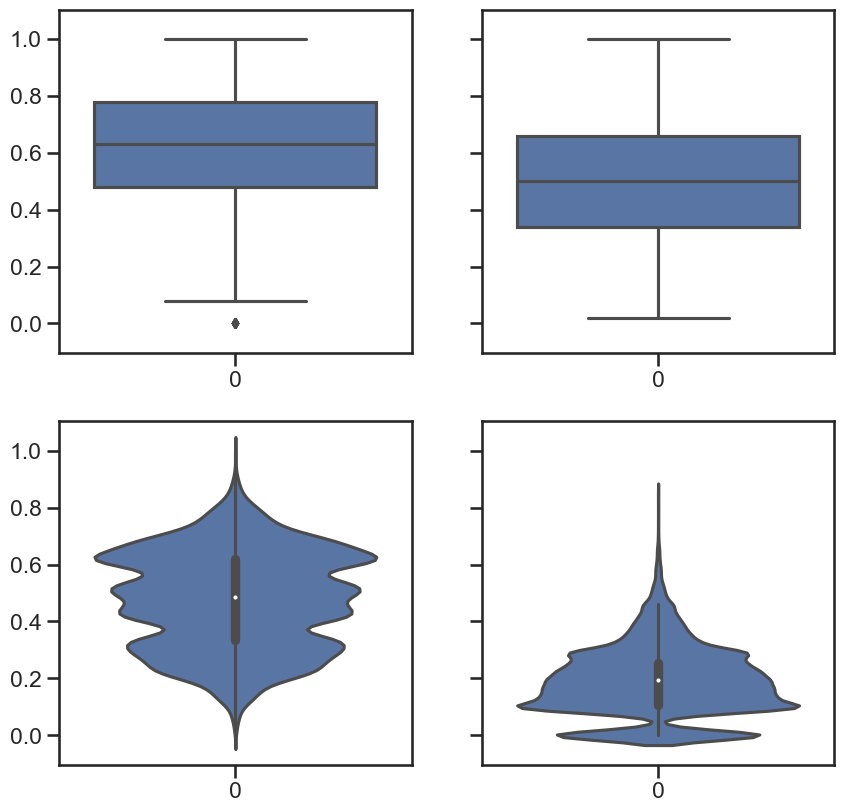

In [30]:
sns.set(context='talk', style='ticks', rc={'figure.figsize':(10,10)}) 

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True)

g1 = sns.boxplot(data=df['hum'],ax=axes[0][0])
g2 = sns.boxplot(data=df['temp'],ax=axes[0][1])

g3 = sns.violinplot(data=df['atemp'],ax=axes[1][0])
g4 = sns.violinplot(data=df['windspeed'],ax=axes[1][1])

plt.show()

利用箱型图得到的分析是考虑单一变量的结果。我们分析了hum、temp、atemp、windspeed四个特征。其中temp、atemp的箱型图没有出现异常值，hum的箱型图中存在异常值，但是是先前已经提取出的零值，而windspeed的箱型图中存在多个偏大的异常值，这里我们分析，风速是一个可以存在较大值的数值，而箱型图给出的异常值实际上并没有那么"异常"，至少在风速这个特征内是可以接受的，因此不认为存在异常值。

## 绘制变量间散点图
通常利用seaborn的pairplot()函数大致查看各组数据之间的相互关系。

pairplot()分别绘制选中的各个变量之间的关系图，沿对角线对称。

默认情况下，此函数将创建一个矩阵图，以便数据中的每个变量在x轴和y轴上存在，如第二行第三列的图反映的是第二与第三个变量之间的关系。

对角线图的处理方式不同：绘制单变量分布图以显示每列中数据的分布情况。

绘图细节：<br>
（1）由于seaborn不能处理Null值，因此在将数据输入时，将Null替换为零。 <br>
（2）为了促进图案的可视化，实现了自定义调色板。 <br>

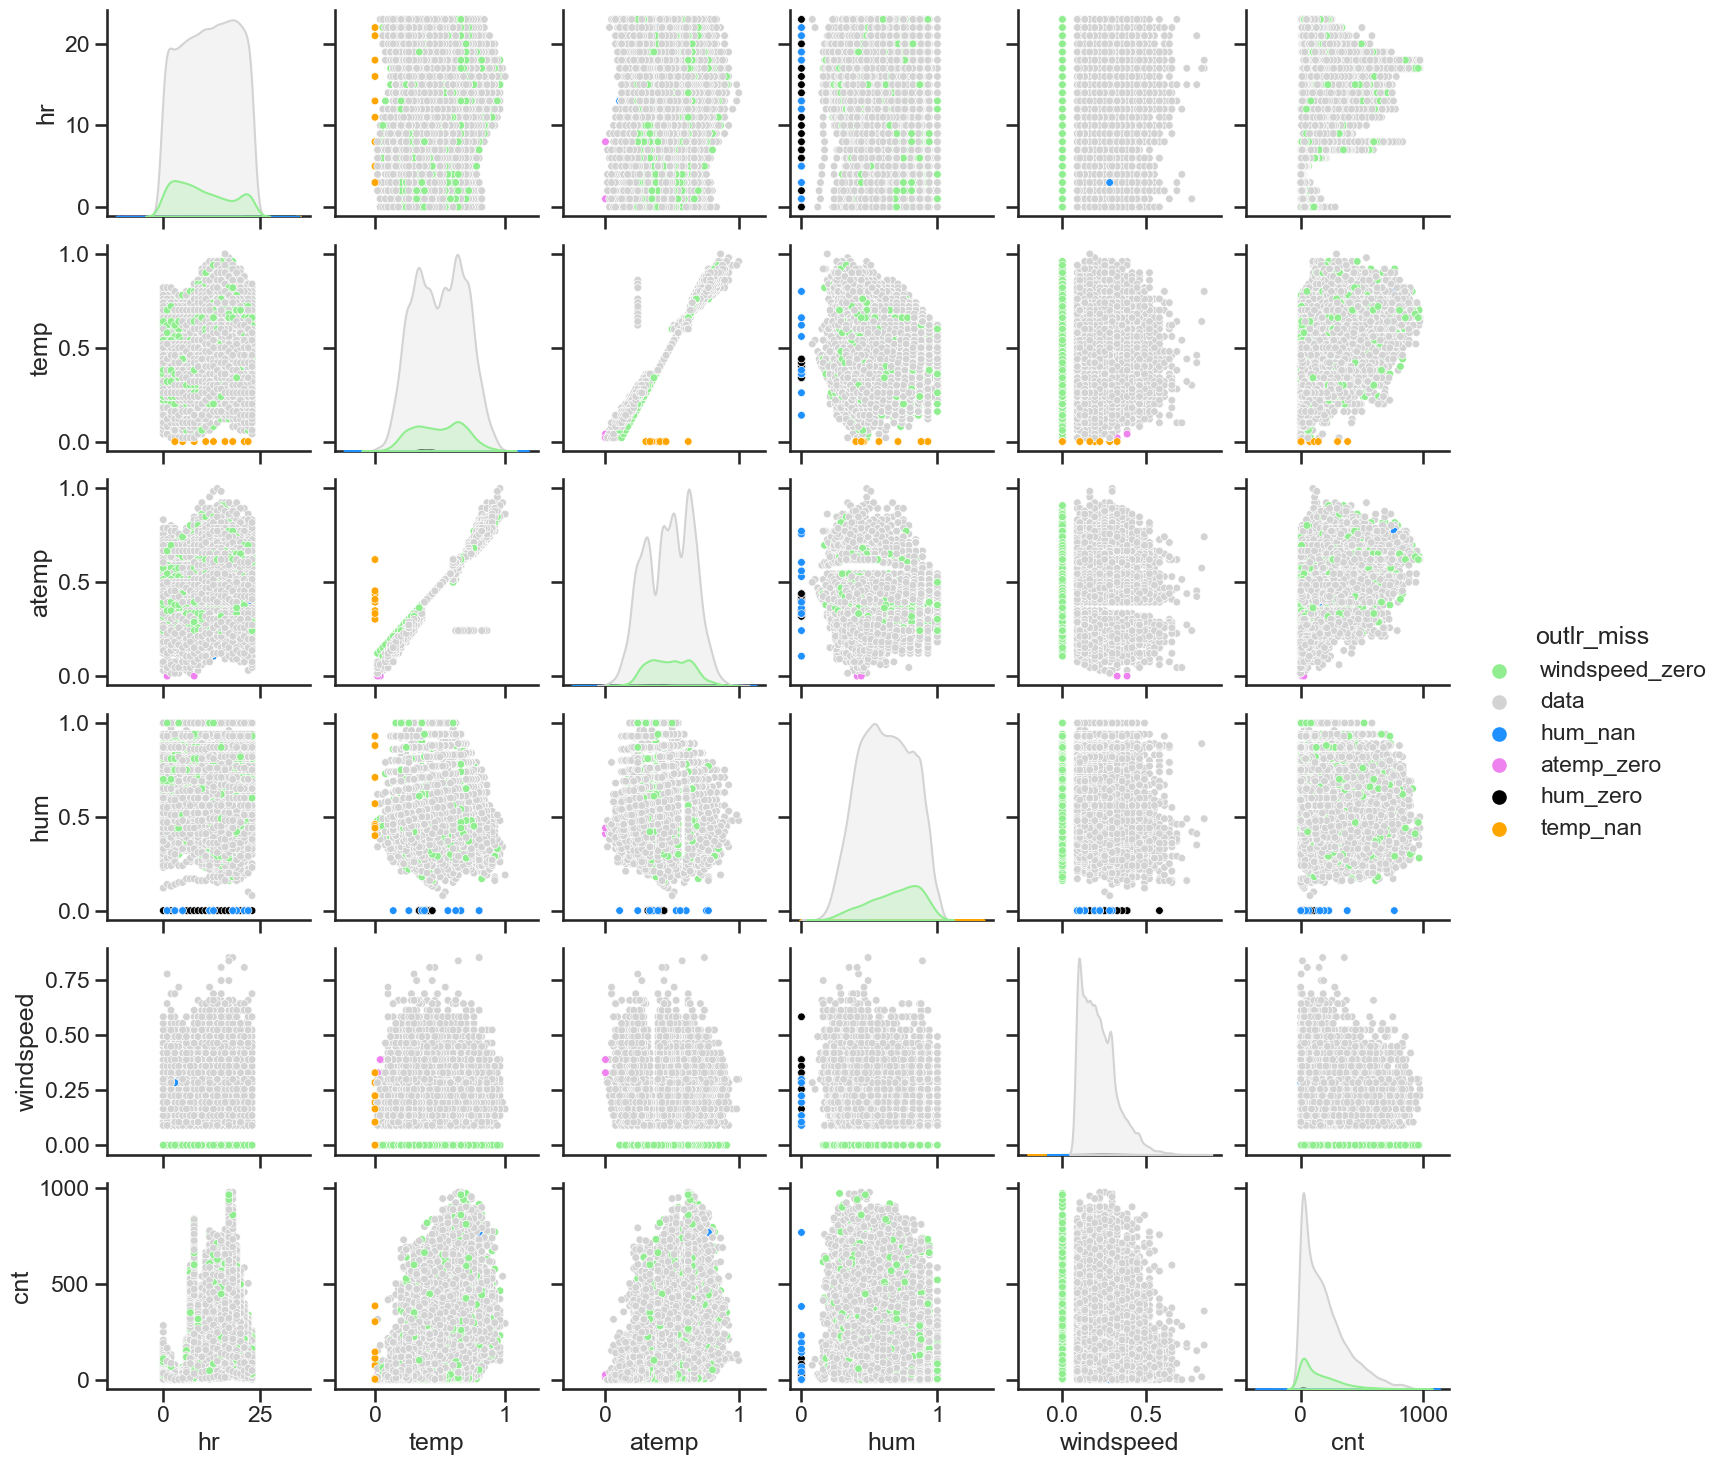

In [32]:
sns.set(context='talk', style='ticks')
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet',}

sns.pairplot(df[ordFeatures + contFeatures + target + ['outlr_miss']].fillna(0),
            hue='outlr_miss', palette=colorPalette, plot_kws = {'s': 30})

plt.show()
plt.close('all')

异常点显示为彩色，正常点显示为灰色点。（见图例）

## 再议异常值
箱型图反映的是单一变量的异常情况。真实情况往往有更加复杂的情况存在。

观察多组数据的散点图，几乎所有偏离数据点主体的异常点都被标记为彩色，说明先前的异常值检测在变量间考量这个维度下取得了效果。

* 然而在temp-atemp图中，发现明显存在一组异常值（偏离于数据点主体的一系列散点），这表示先前的箱型图并没有抓取出变量间存在的异常值。这组数据需要被处理，重新定义为异常点。
* 检查后发现，该组异常值来源于08/17/2012的一组正常值，我们人为将其设置为全新的一类异常值。 

In [34]:
df[(df['temp']>0.5) & (df['atemp'] < 0.4)]

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm,outlr_miss
14131,2012-08-17,fall,0,0,Fri,1,Clear,0.68,0.2424,0.57,...,2012,Aug,8,4,3,True,False,False,False,data
14132,2012-08-17,fall,1,0,Fri,1,Clear,0.66,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14133,2012-08-17,fall,2,0,Fri,1,Clear,0.66,0.2424,0.61,...,2012,Aug,8,4,3,True,False,False,False,data
14134,2012-08-17,fall,3,0,Fri,1,Clear,0.64,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14135,2012-08-17,fall,4,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14136,2012-08-17,fall,5,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14137,2012-08-17,fall,6,0,Fri,1,Clear,0.62,0.2424,0.78,...,2012,Aug,8,4,3,True,False,False,False,data
14138,2012-08-17,fall,7,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14139,2012-08-17,fall,8,0,Fri,1,Clear,0.68,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14140,2012-08-17,fall,9,0,Fri,1,Clear,0.70,0.2424,0.58,...,2012,Aug,8,4,3,True,False,False,False,data


In [35]:
df.loc[df['dteday']=='08/17/2012']

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm,outlr_miss
14131,2012-08-17,fall,0,0,Fri,1,Clear,0.68,0.2424,0.57,...,2012,Aug,8,4,3,True,False,False,False,data
14132,2012-08-17,fall,1,0,Fri,1,Clear,0.66,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14133,2012-08-17,fall,2,0,Fri,1,Clear,0.66,0.2424,0.61,...,2012,Aug,8,4,3,True,False,False,False,data
14134,2012-08-17,fall,3,0,Fri,1,Clear,0.64,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14135,2012-08-17,fall,4,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14136,2012-08-17,fall,5,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14137,2012-08-17,fall,6,0,Fri,1,Clear,0.62,0.2424,0.78,...,2012,Aug,8,4,3,True,False,False,False,data
14138,2012-08-17,fall,7,0,Fri,1,Clear,0.64,0.2424,0.73,...,2012,Aug,8,4,3,True,False,False,False,data
14139,2012-08-17,fall,8,0,Fri,1,Clear,0.68,0.2424,0.65,...,2012,Aug,8,4,3,True,False,False,False,data
14140,2012-08-17,fall,9,0,Fri,1,Clear,0.70,0.2424,0.58,...,2012,Aug,8,4,3,True,False,False,False,data


In [36]:
ts = pd.to_datetime('08/17/2012')
df.loc[(df['outlr_miss']=='data') & df['dteday'].isin([ts]), 'outlr_miss'] = 'atemp_outlr' 

添加一组新的outliers后，更新*'outlr_miss'*列的标签(此时共有7类数据标签)，以下是这些零值的标签编码：

     outlr_miss       
              data     >>  row with no Nulls or Zeros 
          temp_nan     >>  temp column has Null values
           hum_nan     >>  hum column has Null values
        atemp_zero     >>  atemp column has zero values
          hum_zero     >>  hum column has zero values
    windspeed_zero     >>  hum column has zero values
    atemp_outliers     >>  wrong values in atemp-temp graph
    
再次绘制多组数据的散点图

LinAlgError: singular matrix

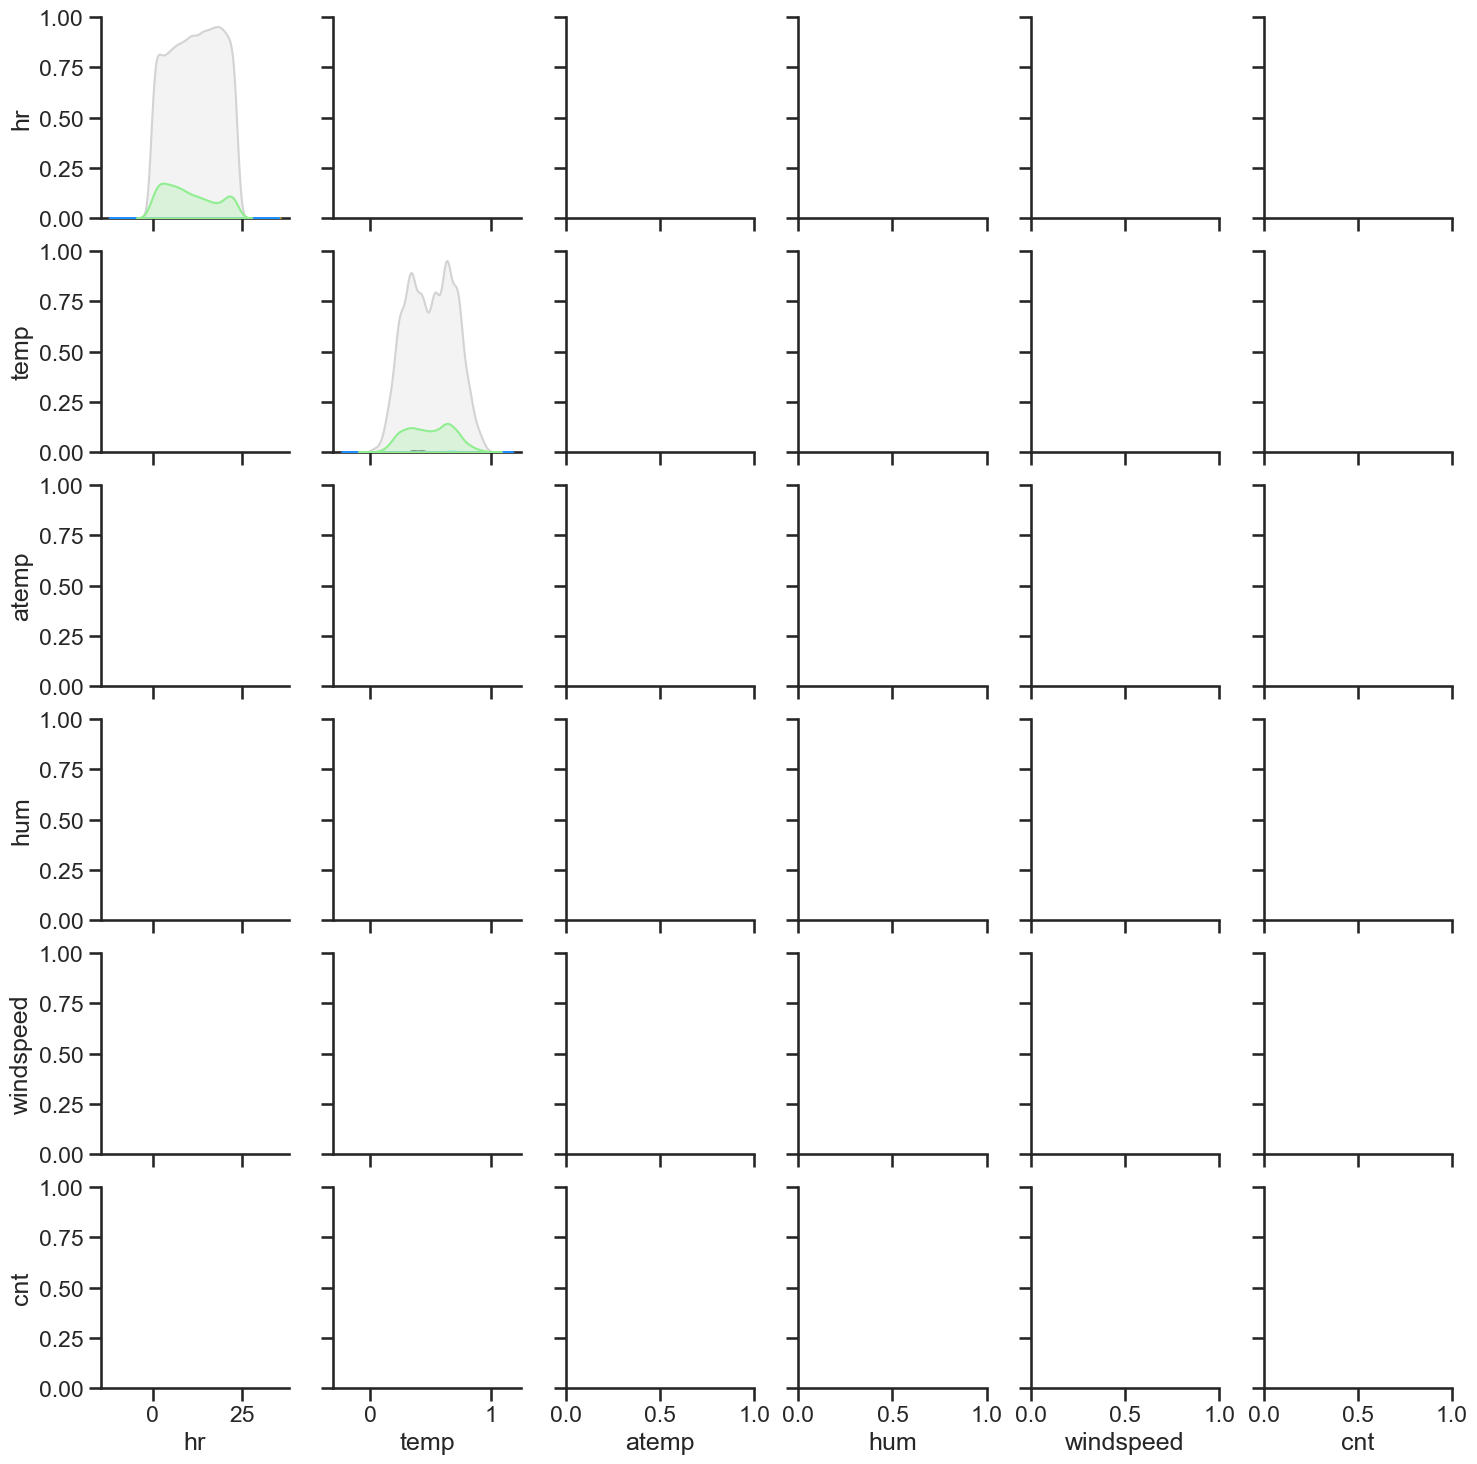

In [37]:
sns.set(context='talk', style='ticks')
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.pairplot(df[ordFeatures + contFeatures + target + ['outlr_miss']].fillna(0),
            hue='outlr_miss', palette=colorPalette, plot_kws = {'s': 30})

plt.show()
plt.close('all')

# 数据清洗——Nulls, Zeros, Outliers
我们已经得到了6类异常的数据，分别是：

          temp_nan     >>  temp column has Null values
           hum_nan     >>  hum column has Null values
        atemp_zero     >>  atemp column has zero values
          hum_zero     >>  hum column has zero values
    windspeed_zero     >>  hum column has zero values
    atemp_outliers     >>  wrong values in atemp-temp graph
    
我们依次处理这些存在异常的数据。

##  处理*'temp'* 与 *'atemp'*中的Nulls,Zeros,outliers
 
观察温度-湿度图，具有温度*'temp'*和温度*'atemp'*的图存在三个可疑值：Nulls,zeros,outliers。

通过常识推测，温度与湿度之间的相互关系可以用于推测出缺少的异常点。这里使用线性回归来预测*'temp'* 与 *'atemp'*中的Nulls,Zeros。<br>

线性回归：利用数理统计中回归分析，来确定两种或两种以上变量间相互依赖的定量关系的一种统计分析方法，运用十分广泛。其表达形式为y = w'x+e，e为误差服从均值为0的正态分布。

利用seaborn绘制处理前后的数据散点图对比，可视化对*'temp'* 与 *'atemp'*中的Nulls,Zeros的处理结果

In [38]:
df_cpy = df.copy(deep=True)

ftr = ['windspeed_zero', 'data', 'hum_nan','hum_zero']
# the df1 will have Nulls for variables other than 'temp' and 'atemp'
df1 = df[df_cpy.outlr_miss.isin(ftr)]

df1 = df1[['temp','atemp']].dropna()

X   = df1['temp'].values.reshape(-1,1)
y   = df1['atemp'].values.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X, y)

df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'atemp'] = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'temp']   = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'temp']     = (df_cpy['atemp'] - regressor.intercept_[0])/regressor.coef_[0][0] 

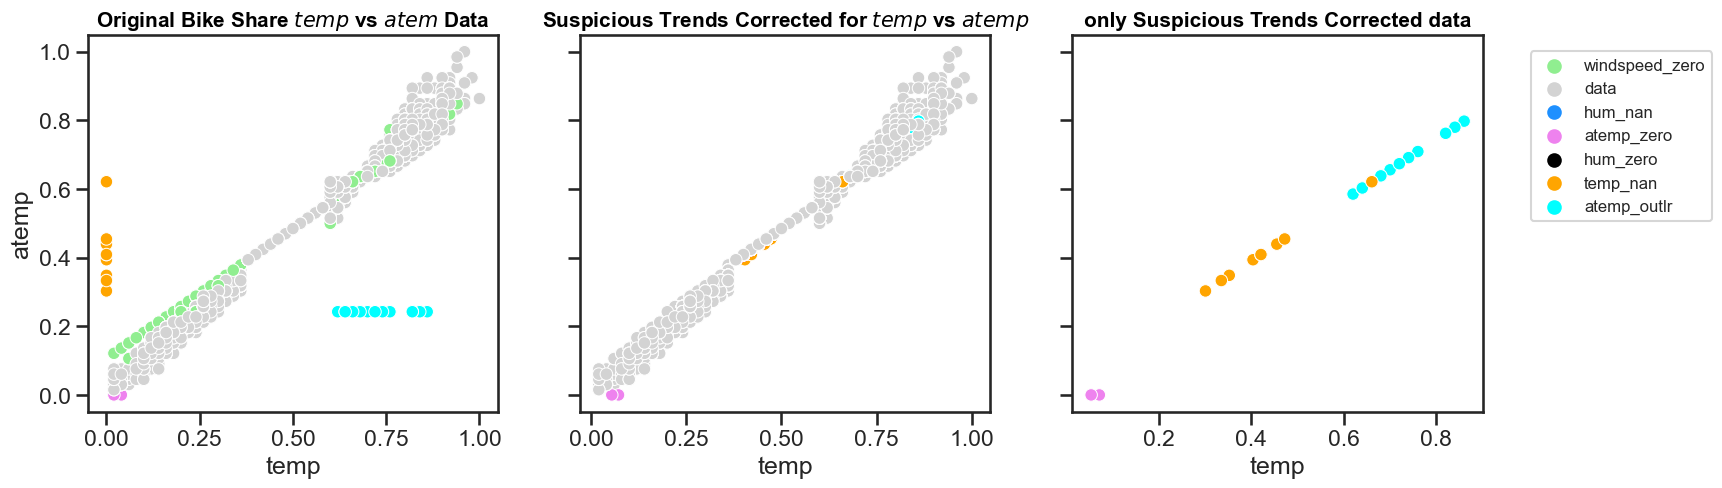

In [39]:
sns.set(context='talk', style='ticks', rc={'figure.figsize':(18,5)}) 

fontdictT={'fontsize': 15, 'weight' : 'bold', 'horizontalalignment': 'center'}

colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

g1 = sns.scatterplot(x='temp', y='atemp', data=df.fillna(0),
                     hue="outlr_miss", palette=colorPalette, 
                     legend='brief', ax=axes[0])

g1.set_title('Original Bike Share $temp$ vs $atem$ Data',
            fontdict=fontdictT, color="black")

colorPalette = ['lightgray','violet', 'orange', 'cyan']
ftr = ['data','atemp_zero', 'temp_nan','atemp_outlr']
g2 = sns.scatterplot(x='temp', y='atemp', data=df_cpy[df_cpy.outlr_miss.isin(ftr)],
                     hue="outlr_miss", palette=colorPalette,
                     legend=False, ax=axes[1])

g2.set_title('Suspicious Trends Corrected for $temp$ vs $atemp$',
            fontdict=fontdictT, color="black")

colorPalette = ['violet', 'orange', 'cyan']
ftr = ['atemp_zero', 'temp_nan','atemp_outlr']
g3 = sns.scatterplot(x='temp', y='atemp', data=df_cpy[df_cpy.outlr_miss.isin(ftr)],
                     hue="outlr_miss", palette=colorPalette,
                     legend=False, ax=axes[2])

g3.set_title('only Suspicious Trends Corrected data',
            fontdict=fontdictT, color="black")

g1.legend(scatterpoints=1, loc='upper right',
           bbox_to_anchor=(4, 1), borderaxespad=1.,
           ncol=1, fontsize=12)

plt.show()
plt.close('all')

观察左右两图，温度*'temp'*和温度*'atemp'*中的异常点Nulls,zeros,outliers已经经过了修改。因此修改异常点数据标签。

In [40]:
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'outlr_miss'] = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'outlr_miss']    = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'outlr_miss']  = 'data'

##  处理湿度*'hum'*中的Nulls,Zeros

科学常识表明，湿度与温度和露点有关，因此，在处理湿度的Nulls和zeros时，应当利用已有的温度与露点数据。
在Bike_Sharing数据集中，可以利用的是湿度，温度，风速和日期，首先，我们可以将这些可能被利用到的参数进行可视化处理，大致感受异常值与相关数据的关系。

参见如下散点图。

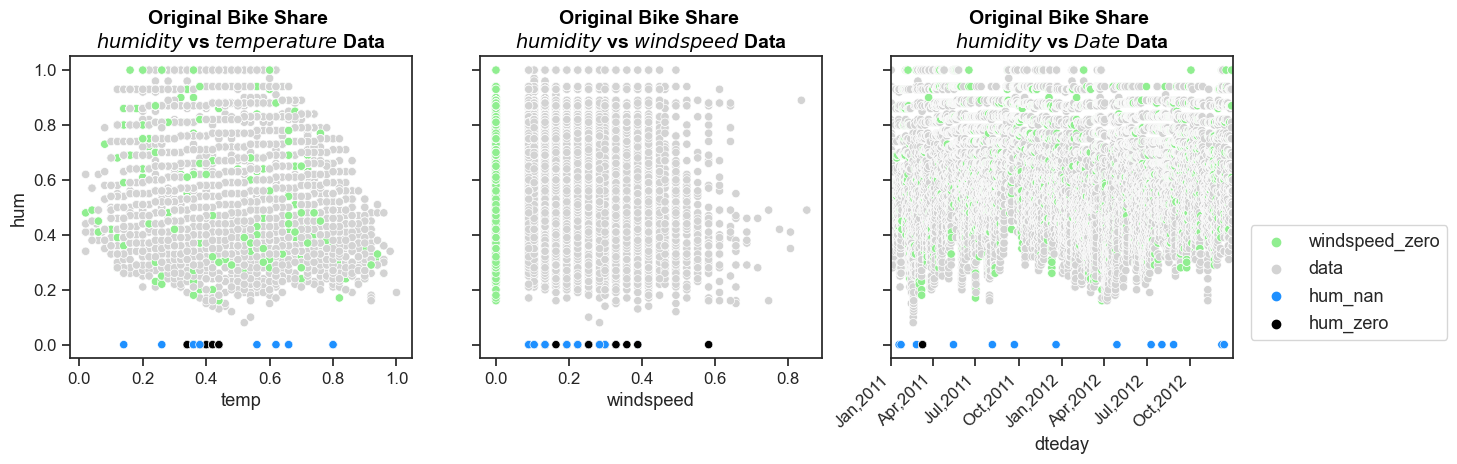

In [41]:
fontdictT    = {'fontsize': 14, 'weight' : 'bold', 'horizontalalignment': 'center'}
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.set( style='ticks', font_scale=1.1, rc={'figure.figsize':(15,4)}) 

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

g = sns.scatterplot(x='temp', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[0])
g.set_title('Original Bike Share \n$humidity$ vs $temperature$ Data',
            fontdict=fontdictT, color="black")

    
g = sns.scatterplot(x='windspeed', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[1])
g.set_title('Original Bike Share \n$humidity$ vs $wind speed$ Data',
            fontdict=fontdictT, color="black")


g = sns.scatterplot(x='dteday', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette, 
                    legend = 'brief', ax=axes[2])
g.set_title('Original Bike Share \n$humidity$ vs $Date$ Data',
            fontdict=fontdictT, color="black")
g.set_xlim(xmin=df_cpy.fillna(0).dteday.min(), xmax=df_cpy.fillna(0).dteday.max())
g.xaxis.set_major_formatter(mdates.DateFormatter("%b,%Y"))
plt.setp(g.get_xticklabels(), rotation=44, ha="right")
g.legend(scatterpoints=1, loc='best', bbox_to_anchor=(1, 0.5),
         borderaxespad=1., ncol=1, fontsize=13)

plt.show()
plt.close('all')

单纯从湿度与温度、风速、日期的两两关系散点图并不能找到特定的规律，因此需要从更多角度分析数据结果。

引入变量hr：考虑到晚上和清晨的温度趋于降低，然后在下午升高，并在一天结束时再次降低这个事实。通过引入变量hr，我们就可以将笼统的日期精细化到每一天的时刻，从而可以更加细致精准地利用一样数据。在粗颗粒度分析无果的情况下，精细化分析是一条必由之路。

从这个角度切入，结合每天的时间查看湿度和温度。下图显示了一天中湿度和温度的变化。

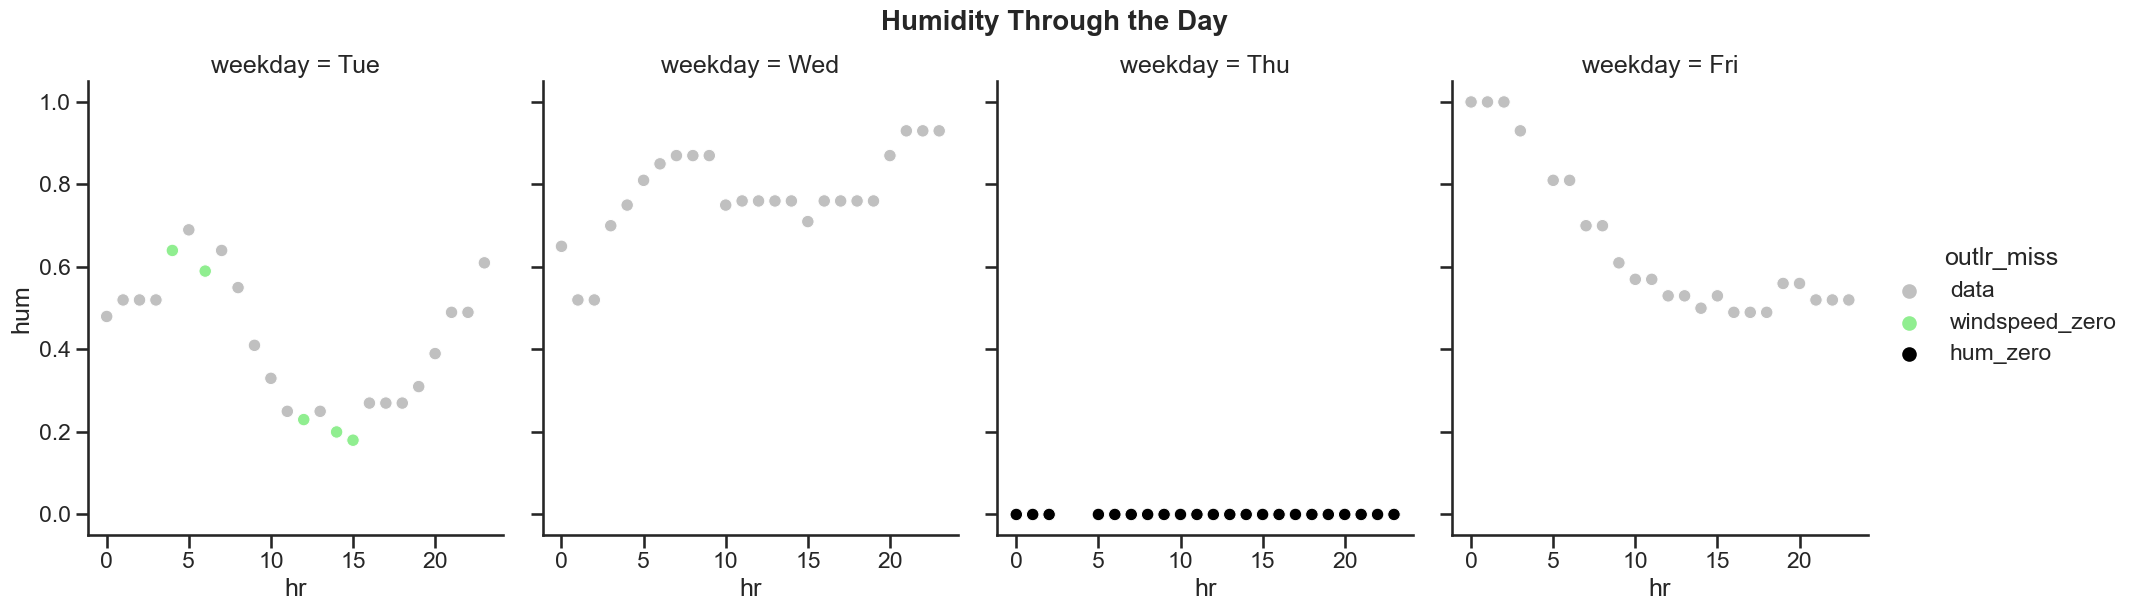

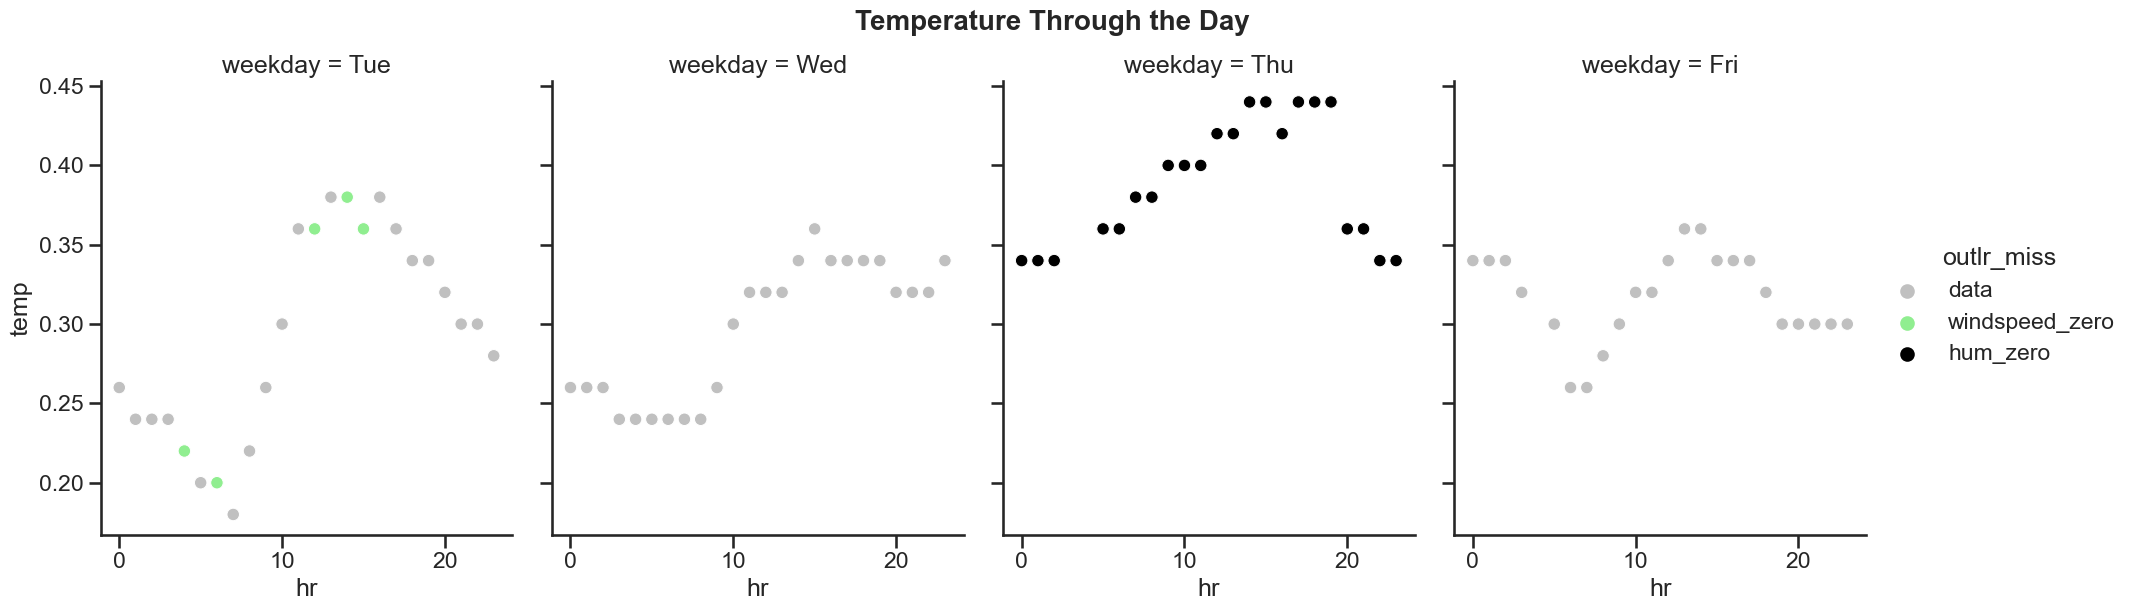

In [42]:
colorPalette = {'data':'silver', 'windspeed_zero':'lightgreen', 'hum_zero':'black', 'hum_nan':'red'}

sns.set(context='talk', style='ticks') 
g = sns.relplot(x="hr", y="hum", col="weekday", hue="outlr_miss",
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette,col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Humidity Through the Day', fontsize=20, fontweight='bold', y=1.03)

g = sns.relplot(x="hr", y="temp", col="weekday", hue="outlr_miss", 
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette, col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Temperature Through the Day', fontsize=20, fontweight='bold', y=1.03)

plt.show()
plt.close('all')

观察得，一天中温度和湿度之间存在相对明显的关系（注意，不是只线性关系，或者简单的正相关/负相关关系）。得到了可以用于预测湿度异常值的关联关系。

下面我们专门绘制一天中温度与湿度的关系图，感受一下两个变量之间在时间这个维度下展示出的相关关系。

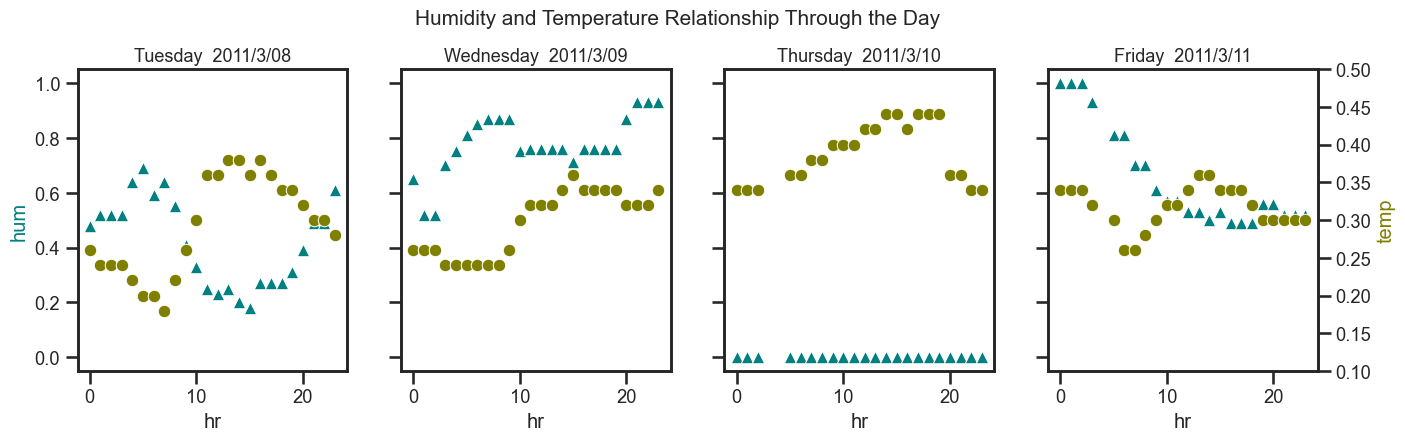

In [43]:
fontdictSubT   = {'fontsize': 13, 'horizontalalignment': 'center'}
day            = ['2011/3/08','2011/3/09','2011/3/10','2011/3/11']
sns.set(context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(16,4)}) 

n_rows, n_cols =1, 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True)
fig.suptitle('Humidity and Temperature Relationship Through the Day\n\n', fontsize=15, y=1.03)

for i, ax in enumerate(axes):
    ax1=sns.scatterplot(x="hr", y="hum", data=df_cpy[(df_cpy.dteday==day[i])].fillna(0),
                        color='teal', marker='^', ax=ax)
    ax1.yaxis.label.set_color('teal')
    week_day = calendar.day_name[datetime.strptime(day[i], '%Y/%m/%d').weekday()]
    ax1.set_title((week_day + "  " + day[i]), fontdict=fontdictSubT)

    ax2 = ax1.twinx()
    ax2 = sns.scatterplot(x="hr", y="temp", data=df_cpy[(df_cpy.dteday==day[i])].fillna(0),
                          color='olive')
    ax2.set_ylim(ymin=0.10, ymax=.5)
    ax2.yaxis.label.set_color('olive')
    if i != (n_cols-1): ax2.get_yaxis().set_visible(False) 

plt.show()
plt.close('all')

# 数据探索

经过处理得到较为干净的数据集后，便可以进行初步的数据探索与分析。通过profile的输出结果，我们能够得知每列数据分布的最大值，最小值，中位数等信息。下面通过箱型图的展示，我们可以对数据整体面貌分布再次加深理解。下图我们选择数据中的五组数据（连续性变量）进行展示。通过绘图我们可以得到以下信息：

* 数据的百分比分布情况，异常值分布情况
* 风速信息存在一些风速过大的异常值，这与异常天气有关，可以接受
* 租用车量信息分布不均衡，可以考虑更换数据表示方式

In [ ]:
df_clean=df_cpy.copy(deep=True)
fig,axes = plt.subplots(1,5)
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
              medians='DarkBlue', caps='Red')
# boxes表示箱体，whisker表示触须线
# medians表示中位数，caps表示最大与最小值界限

axes_list  = ['temp','atemp','hum','windspeed','cnt']
df_clean[axes_list].plot(kind='box',ax=axes,subplots=True,
                              title='Different boxplots',color=color,sym='r+',widths=5)
# sym参数表示异常值标记的方式
 
axes[0].set_ylabel('temp')
axes[1].set_ylabel('atemp')
axes[2].set_ylabel('hum')
axes[3].set_ylabel('windspeed')
axes[4].set_ylabel('cnt')
 
fig.subplots_adjust(wspace=1,hspace=1)  # 调整子图之间的间距

# 单变量数据探索
## 连续变量聚合 
我们可以在数据中采取的方式为根据阈值或分布将它们分成不同的类别。在有的情况下也可以按照数据的分位数进行划分

In [ ]:
# 气温变量聚合
temp_threshold=[0,0.2,0.4,0.6,0.8,1]
df_clean['Temp_threshold']=pd.cut(df_clean['temp'],temp_threshold)


# 湿度变量聚合
hum_threshold=[0,0.2,0.4,0.6,0.8,1]
df_clean['Hum_threshold']=pd.cut(df_clean['hum'],hum_threshold)

#绘图
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
t = sns.boxplot(x='Temp_threshold',y='cnt', data=df_clean,  ax=axes[0])
h = sns.boxplot(x='Hum_threshold',y='cnt', data=df_clean,  ax=axes[1])

plt.show()
plt.close('all')

通过对温度与湿度两变量的聚合处理，我们能够更为明显的看到租车量与两者之间分别呈现正相关与负相关关系

## 单变量对数变换
通过之前的分布观察，租用自行车计数的分布不够均衡，因此可以使用对数变换使分布接近正态分布。这是一个经常采用的数据分析技巧，将对任何建模产生积极影响。

In [ ]:
sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle('Bicycle counts univariate behavior', fontsize=16, y=1)

# 绘制原始数据分布图
g = sns.distplot(df_clean.cnt, bins=10, vertical=True, ax=axes[0])
g = sns.boxplot(y='cnt', data=df_clean, ax=axes[1])
plt.show()
plt.close('all')

In [ ]:
sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle('Bicycle counts univariate behavior - Logarithm transformation', fontsize=16, y=1)

# 进行数据的对数变换
df_clean['logcnt'] = np.log(df_clean['cnt']+1)

# 绘制对数变换后数据分布图
g = sns.distplot(df_clean.logcnt, bins=10, vertical=True, ax=axes[0])
g = sns.boxplot(y='logcnt', data=df_clean,ax=axes[1])
plt.show()
plt.close('all')

# 多变量数据探索
## 相关性分析
对变量之间线性关系的分析是数据探索中的重中之重，其中一种方法是使用相关矩阵，例如Pearson相关系数矩阵。直观地，自行车数取不仅决于与天气状况有关而且与时间有关的变量。因此，相关矩阵包括天气和时间变量。通过看图，可得到以下一些结论：

* 温度“temp”和体感温度“atemp”之间的共线性很明显。通过温度能够得到体感温度，因此将在建模过程中排除体感温度。

* 通常，自行车计数与温度呈正相关，与湿度呈负相关。散点图矩阵的底行显示了这些趋势。然而，这些趋势应与时间维度同时分析。我们将在下一节对此进行详细说明。

相关系数是最早由统计学家卡尔·皮尔逊设计的统计指标，是研究变量之间线性相关程度的量，一般用字母 r 表示。由于研究对象的不同，相关系数有多种定义方式，较为常用的是皮尔逊相关系数。

In [ ]:
corr_mtx = df_clean[["temp","atemp","hum","windspeed","season_int","month_int","weekday_int","hr","logcnt"]].corr()

w = 12
h = 12
d = 70
sns.set( context='talk', style='whitegrid', font_scale=0.9) 
plt.figure(figsize=(w, h), dpi=d)
ax = sns.heatmap(data=corr_mtx, annot=True, square=True, linewidths=1, linecolor='snow', 
                 vmin=np.nanmin(corr_mtx)-0.05, vmax=np.nanmax(corr_mtx)+0.05,
                 cbar_kws={"shrink": .8}, cmap='BuGn')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
plt.close('all')

## 时间变量分析
同样我们按照一些时间上的划分，针对租车数量做箱型图。观察下图中箱型图的中位数（数据的50%以上）；它显示了自行车租赁数量的四个一般特征。1） 租金在逐年增加，2）趋势最初随着时间的推移而增加然后减少，3）趋势随着时间的推移是周期性的，4）异常值的存在。更详细地说，可以导出以下结论：

* 前两图显示，从1月份开始，租车量逐渐增加，保持了整个春季的增长格局，在夏季达到了一个最佳水平。然后，租车量在秋季和冬季下降，这是周期性行为的迹象。
* 中间左面的图表示，在工作日，自行车租赁需求更高。这一现象在第二年更加明显，几乎增加了50%。这种行为表明，自行车租赁的普及率正在上升，至少在这个数据集的城市来源地是这样。
* 中间右面的图显示，人们在假日里骑得更少。然而，这幅图也显示出自行车租赁在这几年里越来越受欢迎。

In [2]:
sns.set(context='talk', style='ticks', font_scale=0.8, palette="Paired")
fig, axes = plt.subplots(nrows=2,ncols=2, sharey=True, figsize=(16,15))
fig.subplots_adjust(hspace=0.3, wspace=0.10)


sns.boxplot(y="cnt",x="season", data=df_clean, orient="v", hue='year', notch=True, ax=axes[0][0])
g = sns.boxplot(y="cnt",x="month", data=df_clean, orient="v", hue='year', notch=True, ax=axes[0][1])
plt.setp(g.get_xticklabels(), rotation=20, ha="right")
sns.boxplot(y="cnt",x="workingday", data=df_clean, orient="v", hue='year', notch=True, ax=axes[1][0])
sns.boxplot(y="cnt",x="holiday", data=df_clean, orient="v", hue='year', notch=True, ax=axes[1][1])


axes[0][0].set(xlabel='Season', ylabel='Count', title="Box Plot On Count Across Season")
axes[0][1].set(xlabel='Month', ylabel='Count', title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Holiday', ylabel='Count', title="Box Plot On Count Across Holiday")

plt.show()
plt.close('all')

NameError: name 'sns' is not defined

我们来看下一组图。通过不同的分类和不同的颜色区别多种变化趋势。连续趋势线的拐点描绘了一天中每小时租用自行车的平均数量。这些趋势线与我们刚才解释的模式和特征相似。这些图给了我们一个额外的信息。虚线表示一天中几个小时内平均温度的变化。这些趋势帮助我们确定，部分变量，（记住这是一个多元分析，湿度、风速和干湿度不在这些图中）如温度对一天中几个小时租赁自行车数量的影响。

* 顶部的图揭示了有趣的趋势。秋季是全天平均气温最高的季节，而春季则是全天最低的平均气温。这些春季最低的平均温度似乎与最低的平均自行车数量有关，这也发生在春季。我们可以说，人们在春天骑自行车不多；也许人们想远离花粉、灰尘等。在这段时间里，人们不想染上过敏症。

* 夏季、秋季和冬季自行车平均数量的趋势有重叠。人们可以认为这可能与气温有关；然而，告诉我们同一季节平均气温的趋势并不重叠。换句话说，平均温度趋势的分离和夏季、秋季和冬季的平均计数趋势的分离不匹配

** 因此，夏季、秋季和冬季的平均温度不会改变自行车的平均需求趋势。然而，由于温度并不是控制天气状况的唯一因素，因此在夏季、秋季和冬季，自行车需求相对稳定，似乎存在着多种因素的混合因素。

** 此外，夏季、秋季和冬季的自行车平均需求量高于春季。

* 最后一个情节也揭示了一个有趣的趋势。一周中的几天里，平均气温保持不变。相较于工作日，周末尤其是早上晚些时候和下午早些时候，对自行车的平均需求更高。

In [ ]:
fig = plt.figure()
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(16,16))
fig.subplots_adjust(hspace=0.25, wspace=0.12)

seasonOrder  = ['spring','summer','fall','winter']
WeekdayOrder = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']

#绘制月度租车量随时间变化图
ax1 = sns.pointplot(x="hr", y="cnt",hue="season",  hue_order=seasonOrder, data=df_clean, 
                    palette='Paired', ax=axes[0])
ax1.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line )', 
        title ="Average Bicycle Count By Hour Of The Day Across Season", label='big')
#绘制月度气温随时间变化图
ax1a = ax1.twinx()
ax1a = sns.pointplot(x="hr", y="temp", hue="season", hue_order=seasonOrder, data=df_clean, 
                     palette='Paired', linestyles=["--","--","--","--"])
ax1a.set(ylabel='Temperature  (dash line)', label='big', ylim=(df_clean.temp.min(),df_clean.temp.max())) 



#绘制星期租车量随时间变化图
ax2 = sns.pointplot(x="hr", y="cnt", hue="weekday", hue_order=WeekdayOrder, data=df_clean,
                    palette='Paired',ax=axes[1])
ax2.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line)',
        title="Average Bicycle Count By Hour Of The Day Across Weekdays",label='big')
#绘制星期气温随时间变化图        
ax2a = ax2.twinx()
ax2a = sns.pointplot(x="hr", y="temp", hue="weekday", hue_order=WeekdayOrder, data=df_clean,
                     palette='Paired', linestyles=["--","--","--","--","--","--","--"])
ax2a.set(ylabel='Temperature  (dash line)', label='big', ylim=(df_clean.temp.min(),df_clean.temp.max()))


plt.show()
plt.close('all')

# 习题
* 探索租车数量分别在2011与2012年间一天中24小时内的变化箱型图
* 寻找适当的方式展示天气与租车数量的关系
* 寻找适当的方式展示风速与租车数量的关系